In [2]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.7 MB/s eta 0:00:00


# Data loading

We have data which is located in 3 different folders.
We extract data from the corresponding folders: urban, sub-urban and village types.




In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
import networkx as nx
import os
from sklearn.metrics import classification_report
import numpy as np
import os
import networkx as nx

def load_graphs_from_folders(root_dir):
    """
    Load all graph files from 'urban', 'suburb', and 'village' folders
    and assign corresponding labels.

    Args:
        root_dir (str): Path to directory containing the three folders

    Returns:
        tuple: (list of NetworkX graphs, list of integer labels)
               Labels: 0=urban, 1=suburb, 2=village
    """
    # Validate root directory exists
    if not os.path.exists(root_dir):
        raise ValueError(f"Root directory not found: {root_dir}")

    # Folder to label mapping (using exact folder names you specified)
    folder_labels = {
        'urban': 0,
        'suburban': 1,  # Note: 'suburb' instead of 'suburban'
        'village': 2
    }

    graphs = []
    labels = []

    for folder_name, label in folder_labels.items():
        folder_path = os.path.join(root_dir, folder_name)

        # Skip if folder doesn't exist
        if not os.path.exists(folder_path):
            print(f"Warning: Missing folder '{folder_name}' - skipping")
            continue

        # Load all .graphml files in folder
        for filename in sorted(os.listdir(folder_path)):
            if not filename.endswith('.ipynb_checkpoints'):
                try:
                    filepath = os.path.join(folder_path, filename)
                    g = nx.read_graphml(filepath)
                    graphs.append(g)
                    labels.append(label)
                    print(f"✓ Loaded {filename} as label {label} ({folder_name})")
                except Exception as e:
                    print(f"× Failed to load {filename}: {str(e)}")
                    continue

    # Verify we loaded some graphs
    if not graphs:
        raise ValueError("No valid graph files found in any folder")

    print(f"\nSuccessfully loaded {len(graphs)} graphs:")
    print(f"- Urban (0): {labels.count(0)} graphs")
    print(f"- Suburb (1): {labels.count(1)} graphs")
    print(f"- Village (2): {labels.count(2)} graphs")

    return graphs, labels

In [4]:
root_dir = 'sample_data'

graphs, labels = load_graphs_from_folders(root_dir)

print(labels)

✓ Loaded Abinsk_34668_town as label 0 (urban)
✓ Loaded Achit_5036_town as label 0 (urban)
✓ Loaded Achkhoy-Martan_16779_town as label 0 (urban)
✓ Loaded Agalatovo_5028_town as label 0 (urban)
✓ Loaded Aleksin_66885_town as label 0 (urban)
✓ Loaded Amurzet_town as label 0 (urban)
✓ Loaded Anadyr_15604_town as label 0 (urban)
✓ Loaded Kosino-Ukhtomsky District_81588_suburb as label 1 (suburban)
✓ Loaded Kotlovka District_65811_suburb as label 1 (suburban)
✓ Loaded Krasnoglinskiy Rayon_66785_suburb as label 1 (suburban)
✓ Loaded Krasnolesnyy_suburb as label 1 (suburban)
✓ Loaded Krylatskoye District_82593_suburb as label 1 (suburban)
✓ Loaded Kryukovo District_97746_suburb as label 1 (suburban)
✓ Loaded Kuntsevo District_151423_suburb as label 1 (suburban)
✓ Loaded Kurkino District_33312_suburb as label 1 (suburban)
✓ Loaded Kuzminki District_145680_suburb as label 1 (suburban)
✓ Loaded Ali-Berdukovskiy_5093_village as label 2 (village)
✓ Loaded Alpatovo_village as label 2 (village)
✓ Loa

# Define model


We start with two main features which we train our model on. These features are degree and clusteirng values.


In [6]:
import torch
import networkx as nx
from torch_geometric.data import Data


In [9]:
import torch
import networkx as nx
from torch_geometric.data import Data

def nx_to_pyg(graphs, labels):

      '''
    Convert NetworkX graphs to PyTorch Geometric Data format with enhanced features.
    Adds degree and clustering coefficients as node features.

    Args:
        graphs: List of NetworkX graphs
        labels: List of corresponding graph labels

    Returns:
        List of PyTorch Geometric Data objects
    '''
    pyg_data_list = []

    for g, label in zip(graphs, labels):
        # Convert to undirected simple graph
        if isinstance(g, (nx.MultiGraph, nx.MultiDiGraph)):
            g = nx.Graph(g)
        elif isinstance(g, nx.DiGraph):
            g = g.to_undirected()

        # Create numerical node mapping for string nodes
        node_mapping = {node: idx for idx, node in enumerate(g.nodes())}

        # Calculate features for all nodes
        max_degree = len(g.nodes()) - 1 if len(g.nodes()) > 1 else 1
        node_features = []

        for node in g.nodes():
            degree = g.degree(node)
            normalized_degree = degree / max_degree
            clustering = nx.clustering(g, node)
            combined_features = [degree, normalized_degree, clustering]
            node_features.append(combined_features)

        # Convert to tensors
        x = torch.tensor(node_features, dtype=torch.float)

        # Convert edges using numerical indices
        edges = [(node_mapping[u], node_mapping[v]) for u, v in g.edges()]
        edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

        # Create Data object
        data = Data(
            x=x,
            edge_index=edge_index,
            y=torch.tensor([label], dtype=torch.long)
        )
        pyg_data_list.append(data)

    return pyg_data_list

In [10]:


# Step 2: GNN Model Architecture
class GNNClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNNClassifier, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.lin = nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        x = global_mean_pool(x, batch)  # Global pooling
        x = self.lin(x)

        return F.log_softmax(x, dim=1)

# Step 3: Training Process
def train_model(data_list):
    # Split data into train/test
    torch.manual_seed(42)
    data_list = [data for data in data_list if data.x.size(0) > 0]  # Filter empty graphs
    train_data = data_list[:int(0.8*len(data_list))]
    test_data = data_list[int(0.2*len(data_list)):]

    train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

    # Initialize model
    model = GNNClassifier(input_dim=train_data[0].num_features,
                          hidden_dim=64,
                          output_dim=3)  # 3 classes

    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.NLLLoss()

    # Training loop
    for epoch in range(100):
        model.train()
        for data in train_loader:
            optimizer.zero_grad()
            out = model(data)
            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        correct = 0
        for data in test_loader:
            pred = model(data).argmax(dim=1)
            correct += int((pred == data.y).sum())
        acc = correct / len(test_loader.dataset)
        print(f'Epoch: {epoch:03d}, Accuracy: {acc:.4f}')

    return model

# Step 4: Classify New Graph
def classify_graph(model, nx_graph):
    # Convert NetworkX graph to PyG format
  # Convert to undirected simple graph (handles MultiGraph/Digraph)
    if isinstance(g, nx.MultiGraph) or isinstance(g, nx.MultiDiGraph):
    # Convert to simple graph by merging multi-edges
      g = nx.Graph(g)
    elif isinstance(g, nx.DiGraph):
      g = g.to_undirected()

    # Calculate global degree for normalization
    max_degree = len(g.nodes()) - 1 if len(g.nodes()) > 1 else 1

    for node in g.nodes():
    # Get original features if they exist, otherwise empty list
    # original_features = list(g.nodes[node].get('features', []))

        # Calculate networkx properties
      degree = g.degree(node)
      normalized_degree = degree / max_degree
      clustering = nx.clustering(g, node)

    # Combine all features
    combined_features = [degree, normalized_degree, clustering]
    #node_features.append(combined_features)

    # Convert to tensor
    x = torch.tensor(combined_features, dtype=torch.float)

    #x = torch.tensor([nx_graph.nodes[n]['features'] for n in nx_graph.nodes()], dtype=torch.float)
    edge_index = torch.tensor(list(nx_graph.edges())).t().contiguous()
    data = Data(x=x, edge_index=edge_index)

    # Add batch dimension
    data.batch = torch.zeros(data.num_nodes, dtype=torch.long)

    # Predict
    model.eval()
    with torch.no_grad():
        pred = model(data).argmax(dim=1).item()

    classes = ['urban', 'suburban', 'city']
    return classes[pred]


In [11]:

# Main Execution
if __name__ == "__main__":
    # 1. Load and prepare data
    graphs, labels = load_graphs_from_folders('sample_data')
    data_list = nx_to_pyg(graphs, labels)

    # 2. Train model
    model = train_model(data_list)


✓ Loaded Abinsk_34668_town as label 0 (urban)
✓ Loaded Achit_5036_town as label 0 (urban)
✓ Loaded Achkhoy-Martan_16779_town as label 0 (urban)
✓ Loaded Agalatovo_5028_town as label 0 (urban)
✓ Loaded Aleksin_66885_town as label 0 (urban)
✓ Loaded Amurzet_town as label 0 (urban)
✓ Loaded Anadyr_15604_town as label 0 (urban)
✓ Loaded Kosino-Ukhtomsky District_81588_suburb as label 1 (suburban)
✓ Loaded Kotlovka District_65811_suburb as label 1 (suburban)
✓ Loaded Krasnoglinskiy Rayon_66785_suburb as label 1 (suburban)
✓ Loaded Krasnolesnyy_suburb as label 1 (suburban)
✓ Loaded Krylatskoye District_82593_suburb as label 1 (suburban)
✓ Loaded Kryukovo District_97746_suburb as label 1 (suburban)
✓ Loaded Kuntsevo District_151423_suburb as label 1 (suburban)
✓ Loaded Kurkino District_33312_suburb as label 1 (suburban)
✓ Loaded Kuzminki District_145680_suburb as label 1 (suburban)
✓ Loaded Ali-Berdukovskiy_5093_village as label 2 (village)
✓ Loaded Alpatovo_village as label 2 (village)
✓ Loa

/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 000, Accuracy: 0.4286
Epoch: 001, Accuracy: 0.4286
Epoch: 002, Accuracy: 0.4286
Epoch: 003, Accuracy: 0.4286
Epoch: 004, Accuracy: 0.4286
Epoch: 005, Accuracy: 0.4286
Epoch: 006, Accuracy: 0.4286
Epoch: 007, Accuracy: 0.4286
Epoch: 008, Accuracy: 0.4286
Epoch: 009, Accuracy: 0.4286
Epoch: 010, Accuracy: 0.4286
Epoch: 011, Accuracy: 0.4286
Epoch: 012, Accuracy: 0.4286
Epoch: 013, Accuracy: 0.4286
Epoch: 014, Accuracy: 0.4286
Epoch: 015, Accuracy: 0.4286
Epoch: 016, Accuracy: 0.4286
Epoch: 017, Accuracy: 0.4286
Epoch: 018, Accuracy: 0.4286
Epoch: 019, Accuracy: 0.4286
Epoch: 020, Accuracy: 0.4286
Epoch: 021, Accuracy: 0.4286
Epoch: 022, Accuracy: 0.4286
Epoch: 023, Accuracy: 0.4286
Epoch: 024, Accuracy: 0.4286
Epoch: 025, Accuracy: 0.4286
Epoch: 026, Accuracy: 0.4286
Epoch: 027, Accuracy: 0.4286
Epoch: 028, Accuracy: 0.4286
Epoch: 029, Accuracy: 0.4286
Epoch: 030, Accuracy: 0.4286
Epoch: 031, Accuracy: 0.4286
Epoch: 032, Accuracy: 0.4286
Epoch: 033, Accuracy: 0.4286
Epoch: 034, Ac

In [ ]:
# you need to insert the levels and new names for the data loader specifications
# you need to add parameters from within the model itself

accuracies = train_model(
    model= GNNClassifier,
    loader=train_loader,
    optimizer=optimizer,
    criterion=criterion,
    num_epochs=100
)


plt.figure(figsize=(10, 5))
plt.plot(accuracies, 'b-o')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(range(len(accuracies)), [f"{i:03}" for i in range(len(accuracies))])
plt.grid(True)
plt.ylim(0, 1.0)
plt.show()

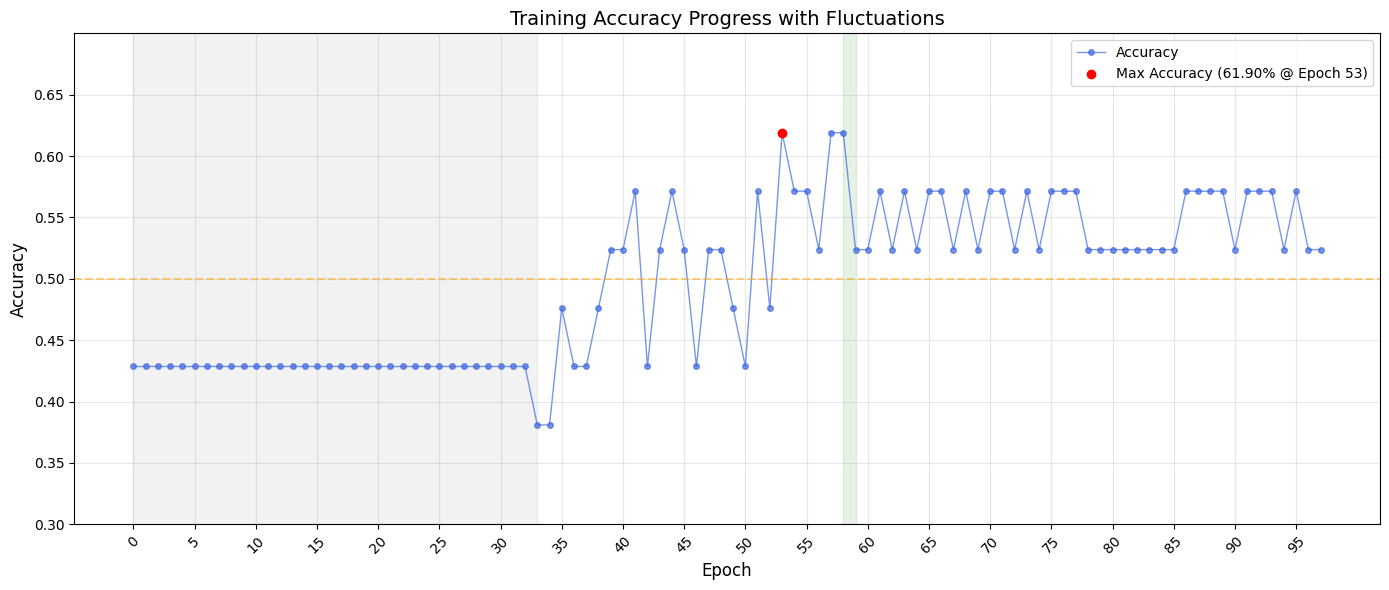

# Predict your graph types

In [ ]:

# 3. Classify a new graph (example)
new_graph = nx.read_graphml('sample_data/suburban/Krasnolesnyy_suburb')
prediction = classify_graph(model, new_graph)
print(f"The graph is classified as: {prediction}")